In [2]:
!pip install langchain_experimental -q

In [1]:
from langchain_experimental.tools.python.tool import PythonAstREPLTool
import pandas as pd

df = pd.read_csv("data/titanic.csv")
python_repl_ast = PythonAstREPLTool(locals={'df':df})
tool_map = {'python_repl_ast': python_repl_ast}

tool = 'python_repl_ast'
tool_input = 'df.head(3)'

tool_map[tool].run(tool_input)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Unnamed: 12
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,NaN
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN


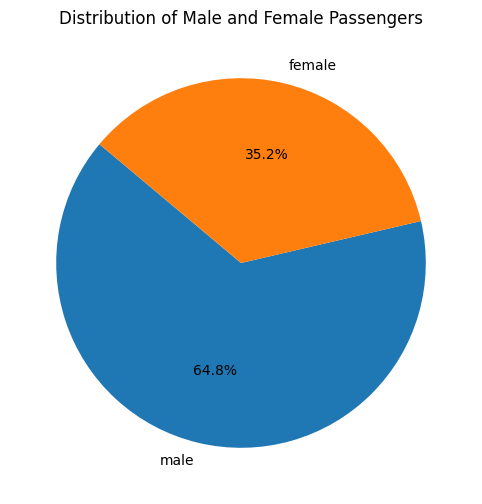

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

# Count the number of males and females
sex_counts = df['Sex'].value_counts()

# Plot a pie chart showing the distribution of male and female passengers
plt.figure(figsize=(8, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Male and Female Passengers')
plt.show()

In [6]:
from utils import chat_invoke, template_substitute, json_loads

input = '年龄大于22岁的乘客共几名'
scratchpad = [
        {
            "Thought":"回答用户问题，前我需要观察一下数据例名",
            "Tool": "python_repl_ast",
            "Tool Input":"df.columns",
            "Observation":"Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Unnamed: 12'], dtype='object')"
        }
    ]

prompt = template_substitute('agent', input=input, scratchpad=scratchpad)
result = chat_invoke(prompt)
print(result)

 
```json
{
    "Question": "年龄大于22岁的乘客共几名？",
    "Scratchpad": [
        {
            "Thought": "回答用户问题，前我需要观察一下数据列名",
            "Tool": "python_repl_ast",
            "Tool Input": "df.columns",
            "Observation": "Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Unnamed: 12'], dtype='object')"
        }
    ],
    "Thought": "为了回答这个问题，我需要计算年龄大于22岁的乘客数量。这可以通过筛选df中'Age'列大于22的行来实现。",
    "Tool": "python_repl_ast",
    "Tool Input": "print(df[df['Age'] > 22].shape[0])",
    "Observation": null,
    "Finished": 0
}
```


In [7]:
obj = json_loads(result)

thought  = obj['Thought']

tool = obj['Tool']
tool_input = obj['Tool Input']
observation = tool_map[tool].run(tool_input)
print(observation)

483



In [8]:

input_ = '用饼图显示男女乘客分布比例'
prompt = template_substitute('agent', input=input_, scratchpad=scratchpad)
result = chat_invoke(prompt)
print(result)

 
```json
{
    "Question": "用饼图显示男女乘客分布比例",
    "Scratchpad": [
        {
            "Thought": "回答这个问题，我需要计算男女乘客的数量，并使用matplotlib库绘制饼图。",
            "Tool": "python_repl_ast",
            "Tool Input": "df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['male', 'female'])",
            "Observation": "None"
        }
    ],
    "Thought": "我已经编写了代码来计算男女乘客的数量，并使用matplotlib库绘制饼图。",
    "Tool": "python_repl_ast",
    "Tool Input": "df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['male', 'female'])",
    "Observation": "None",
    "Finished": 0,
    "Answer": "正在绘制饼图，请稍等..."
}
```


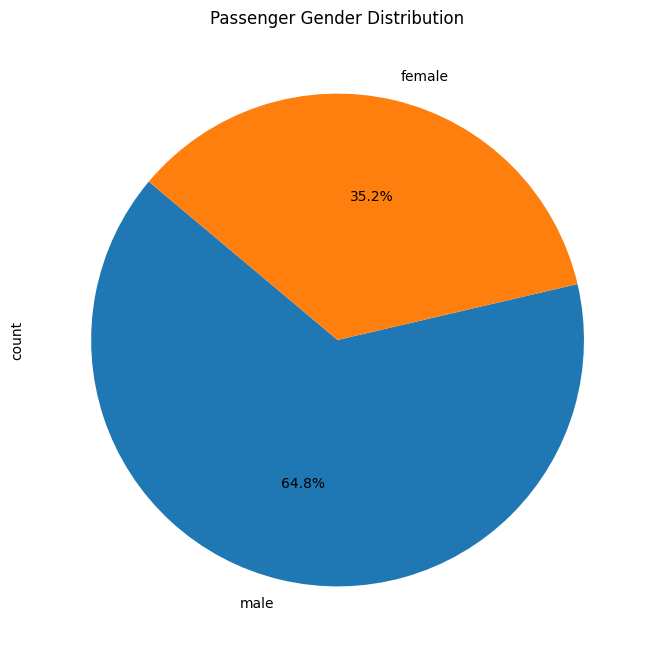

In [30]:
from utils import json_loads

obj = json_loads(result)
thought  = obj['Scratchpad'][1]['Thought']
tool = obj['Scratchpad'][1]['Tool']
tool_input = obj['Scratchpad'][1]['Tool Input']
observation = tool_map[tool].run(tool_input)

In [31]:
from utils import json_loads, chat_invoke, template_substitute
from langchain_experimental.tools.python.tool import PythonAstREPLTool
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv("data/titanic.csv")
python_repl_ast = PythonAstREPLTool(locals={'df':df})
tool_map = {'python_repl_ast': python_repl_ast}

scratchpad = [
        {
            "Thought":"回答用户问题，前我需要观察一下数据例名",
            "Tool": "python_repl_ast",
            "Tool Input":"df.columns",
            "Observation":"Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Unnamed: 12'], dtype='object')"
        }
    ]


def agent(query, scratchpad={}, max_request_time=10):
    cur_request_imte = 0
    finished = 0
    while cur_request_imte < max_request_time and finished == 0:
        cur_request_imte += 1
        obj = invoke(query, scratchpad)
        scratchpad = excute(obj, scratchpad)
        
        finished = obj['Finished']
        if finished == 1:
            print('Final Answer: ', obj['Answer'])
            
                        
def excute(obj, scratchpad):
    # 执行代码获得结果
    tool = obj['Tool']
    tool_input = obj['Tool Input']
    observation = tool_map[tool].run(tool_input) 
    
    # 记录scatchpad
    thought = obj['Thought']
    scratchpad.append({
        'Thought':thought,
        'Tool': tool,
        'Tool Input':tool_input,
        'observation':observation
    })
    
    return scratchpad

def invoke(query, scratchpad):
    prompt = template_substitute('agent', input=query, scratchpad=scratchpad)
    # print('INPUT'.center(30, '#'), prompt, sep='\n')
    result = chat_invoke(prompt)
    print('OUTPUT'.center(30, '#'), result, sep='\n')
    return json_loads(result)

############OUTPUT############
 
```json
{
    "Question": "用饼图显示男女乘客分布比例",
    "Scratchpad": [
        {
            "Thought": "回答这个问题，我需要计算男女乘客的数量，并使用matplotlib库绘制饼图。",
            "Tool": "python_repl_ast",
            "Tool Input": "df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['male', 'female'])",
            "Observation": "None"
        }
    ],
    "Thought": "我已经编写了代码来计算男女乘客的数量，并使用matplotlib库绘制饼图。",
    "Tool": "python_repl_ast",
    "Tool Input": "df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['male', 'female'])",
    "Observation": "None",
    "Finished": 0,
    "Answer": "正在绘制饼图，请稍等..."
}
```
############OUTPUT############
 
```json
{
    "Question": "用饼图显示男女乘客分布比例",
    "Scratchpad": [
        {
            "Thought": "回答用户问题，前我需要观察一下数据例名",
            "Tool": "python_repl_ast",
            "Tool Input": "df.columns",
            "Observation": "Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',

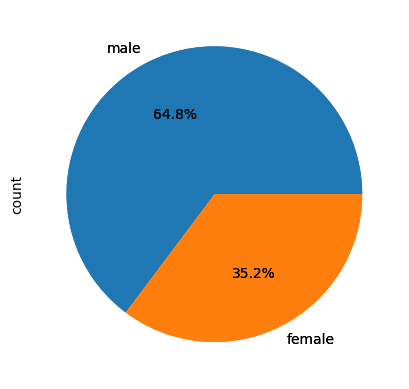

In [32]:
agent('用饼图显示男女乘客分布比例', scratchpad)

In [21]:
agent('30以上的男性乘客有多少幸存', scratchpad)

Final Answer:  30岁以上的男性乘客中，有41人幸存。


Final Answer:  我已经用柱状图显示了船舱等级（Pclass）的分布情况。


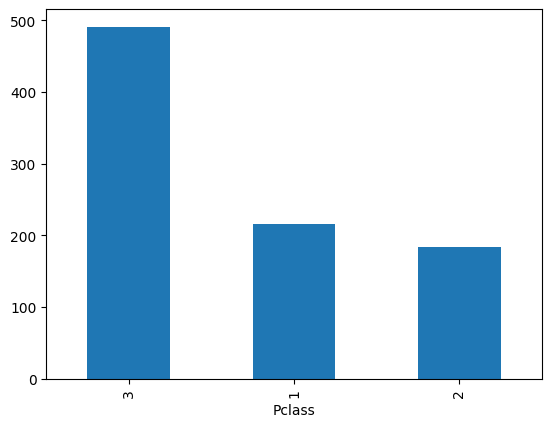

In [27]:
agent('用柱状图显示船舱等级(Pclass)分布情况', scratchpad)